# Simple RGCs simulation

In [1]:
import numpy as np, array
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal
import matplotlib.image as mpimg
import matplotlib.cm as cm
import math
from mpl_toolkits.mplot3d import axes3d

import torch
from collections import OrderedDict
import neuralpredictors as neur
from neuralpredictors.data.datasets import StaticImageSet, FileTreeDataset

from numpy import save

In [2]:
#Save notebook session
#dill.dump_session('Natural_images_dataset_session_09122020.db')

In [3]:
#Restore notebook session
#dill.load_session('Natural_images_dataset_session_09122020.db')

##### Simple RGCs simulation:

In [4]:
_default_2Dgaussian_p = (1,1,1,0,0,0,0)
def gaussian_2D(xz, sigma_x, sigma_z, amp, theta, x0, z0, y0):
    """Two dimensional Gaussian function
    params:
        - xz: meshgrid of x and z coordinates at which to evaluate the points
        - sigma_x: width of the gaussian
        - sigma_z: height of the gaussian
        - amp: amplitude of the gaussian
        - theta: angle of the gaussian (in radian)
        - x0: shift in x of the gaussian
        - z0: shift in z of the gaussian
        - y0: shift in y of the gaussian
    """
    (x,z) = xz
    x0, z0 = float(x0), float(z0)
    a =  (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_z**2)
    b = -(np.sin(2*theta)) /(4*sigma_x**2) + (np.sin(2*theta)) /(4*sigma_z**2)
    c =  (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_z**2)
    g = amp * np.exp( -(a*((x-x0)**2) + 2*b*(x-x0)*(z-z0) + c*((z-z0)**2))) + y0
    return g.ravel()

def mexicanHat(xz, sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1,
                           sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0):
    """Sum of two 2D Gaussian function. For the params, see `gaussian_2D`.
     However, both share the y0 parameter."""
    return (gaussian_2D(xz, sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1, 0) 
            + gaussian_2D(xz, sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, 0) + y0)

def ELU(r):
    if r>0:
        return r+1
    else:
        return np.exp(r) + 1    
    
def RF(vis_field_width, vis_field_height, rf_theta, x_rf_center, z_rf_center, polarity, plot=False):
    x,y = np.meshgrid(np.linspace(0,vis_field_width,vis_field_width),np.linspace(0,vis_field_height,vis_field_height))
    
    if polarity==1:
        sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1 = 1, 2, 1, rf_theta, x_rf_center, z_rf_center
        sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0 = 2, 3, -0.5, rf_theta, x_rf_center, z_rf_center, 0
    else:
        sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1 = 1, 2, -1, rf_theta, x_rf_center, z_rf_center
        sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0 = 2, 3, 0.5, rf_theta, x_rf_center, z_rf_center, 0
        
    z = mexicanHat((x,y), sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1,
                           sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0).reshape(vis_field_height,vis_field_width)
    if plot==True:
        fig = plt.figure(figsize=(5,4))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(x, y, z, rstride=3, cstride=3, label=f"x_rf_center={x_rf_center}  z_rf_center={z_rf_center} \n amp_center={amp_1}  amp_surround={amp_2}")
        _ = ax.legend()
    return z

def RGC_response(rf, image, plot=False, seed=None):
    Img_barHat = image * rf
    
    if plot==True:
        fig, ax = plt.subplots(3, figsize=(7,7))
        ax[0].imshow(image)
        ax[0].set_title("Image")
        ax[1].imshow(rf)
        ax[1].set_title("RGC RF")
        ax[2].imshow(Img_barHat)
        ax[2].set_title("RGC Response")
        plt.tight_layout()
    if seed is not None:
        np.random.seed(seed)
        
    g = ELU(sum(Img_barHat.ravel()))
    spikes = np.random.poisson(lam=g, size=None)
    return spikes

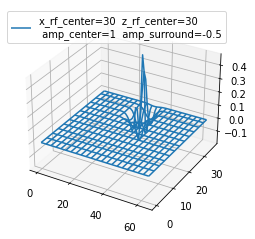

In [27]:
#Generate the receptive field of one RGC
rf = RF(vis_field_width = 64, vis_field_height = 36, rf_theta = 1.2, x_rf_center = 30, z_rf_center = 30, polarity =1, plot=True)

In [24]:
np.load('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/data/responses/'+str(555)+'.npy')

array([  1,  41,   3, ..., 279,   0, 299])

1

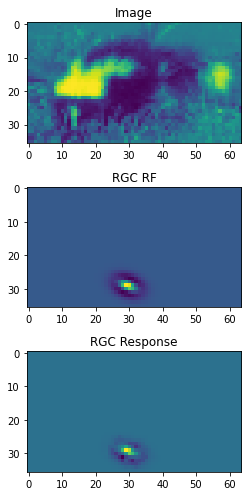

In [28]:
#rf = np.load('D://inception_loop/RGC_sim_data/data/static27012021_original_images/RFs/990.npy')
#x = images[2]
#Generate the response of one RGC
RGC_response(rf=rf, image=x, plot=True)
#plt.savefig("D://inception_loop/RGC_sim_data/results/Image_RF_response.png")

##### RGCs response generation to natural images dataset:

In [119]:
np.load('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/data/images/5992.npy')

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [117]:
#Retrieve image sets from evaluation data set of lurz2020 #5993 images randomly selected as train, validation or test
paths = 'D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/data/images'

images = []
for n in range(5993):
    x = np.load(paths+'/'+str(n)+'.npy')
    x_padded = np.pad(x[0], pad_width=20, mode='constant', 
              constant_values=0)
    np.save(paths+'/'+str(n)+'.npy', [x_padded])
     #images.append(x)
    
#images = np.vstack(images)

ValueError: need at least one array to concatenate

In [101]:
#Generate receptive fields of several RGCs #2304 RGCs - haf ON/half OFFù
import random
rf_ON = []
rf_ON_center_coord = []
rf_OFF = []
rf_OFF_center_coord = []
i = 0
image = images[0]
for width_center in range(image.shape[1]):
    for height_center in range(image.shape[0]):
        if (i % 2) == 0:
            theta = random.uniform(0, 6.2)
            rf = RF(image.shape[1], image.shape[0], theta, width_center, height_center, 1, plot=False) 
            rf_ON.append(rf)
            rf_ON_center_coord = np.array([width_center, height_center])
            save('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/RFs/'+str(i)+'.npy', rf_ON)
        else:
            theta = random.uniform(0, 6.2)
            rf = RF(image.shape[1], image.shape[0], theta, width_center, height_center, -1, plot=False) 
            rf_OFF.append(rf)
            rf_OFF_center_coord = np.array([width_center, height_center])
            save('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/RFs/'+str(i)+'.npy', rf_OFF)
        i+=1

In [102]:
#Generate responses of simulated RGCs to the image set from evaluation data set of lurz2020
import time
start_time = time.time()

i=0
for image in images:
    responses = []
    for rfon, rfoff in zip(rf_ON, rf_OFF):
        rgc_on_response = RGC_response(rf=rfon, image=image, plot=False)
        responses.append(rgc_on_response)
        rgc_off_response = RGC_response(rf=rfoff, image=image, plot=False)
        responses.append(rgc_off_response)
    # save numpy array as npy file
    save('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/data/responses/'+str(i)+'.npy', responses)
    if (i % 1000) == 0:
        print(i)
    i+=1
    
print("--- %s seconds ---" % (time.time() - start_time))

0
1000
2000
3000
4000
5000
--- 5198.415756702423 seconds ---


In [248]:
#Generate data - pupil_center npy files
#Array with list of two values- coordinates of pupil center - [759.87785056, 472.71767702]

for j in range(len(images)):
    pupil_center = np.array([0.0,0.0])
    # save numpy array as npy file
    save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/data/pupil_center/'+str(j)+'.npy', pupil_center)

In [ ]:
#Generate data - behavior npy files -> use include_behavior= False in static_loaders
#Array with list of three values - pupil dilation, temporal derivative and absolute running speed - [99.2678426 ,  6.66429682,  0. ] 

In [266]:
#Generate metadata - neurons - unit_ids npy array
unit_ids = np.array(range(1, len(responses)+1))
#Generate metadata - neurons - animal_ids npy array
animal_ids = np.repeat(1, len(responses))
#Generate metadata - neurons - area npy array
area = ['retina']*len(responses)
#Generate metadata - neurons - layer npy array
layer = ['RGC']*len(responses)
#Generate metadata - neurons - scan_idx npy array
scan_idx = np.repeat(14, len(responses))
#Generate metadata - neurons - sessions npy array
sessions = np.repeat(6, len(responses))

# save numpy arrays as npy arrays
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/neurons/unit_ids.npy', unit_ids)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/neurons/animal_ids.npy', animal_ids)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/neurons/area.npy', area)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/neurons/layer.npy', layer)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/neurons/scan_idx.npy', scan_idx)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/neurons/sessions.npy', sessions)

In [267]:
#Generate metadata - trials - animal_id npy array
animal_id = np.repeat(1, len(responses))
#Generate metadata - trials - scan_idx npy array
scan_idx = np.repeat(14, len(responses))
#Generate metadata - trials - session npy array
session = np.repeat(6, len(responses))

# save numpy arrays as npy arrays
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/trials/animal_id.npy', animal_id)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/trials/scan_idx.npy', scan_idx)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/trials/session.npy', session)

In [269]:
#Generate metadata - statistics - pupil_center - all
pupil_center_max_all = np.array([0.0,0.0])
pupil_center_mean_all = np.array([0.0,0.0])
pupil_center_median_all = np.array([0.0,0.0])
pupil_center_min_all = np.array([0.0,0.0])
pupil_center_std_all = np.array([0.0,0.0])
#Generate metadata - statistics - pupil_center - stimulus_frame
pupil_center_max_sf = np.array([0.0,0.0])
pupil_center_mean_sf = np.array([0.0,0.0])
pupil_center_median_sf = np.array([0.0,0.0])
pupil_center_min_sf = np.array([0.0,0.0])
pupil_center_std_sf = np.array([0.0,0.0])

# save numpy arrays as npy arrays - all
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/all/max.npy', pupil_center_max_all)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/all/mean.npy', pupil_center_mean_all)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/all/median.npy', pupil_center_median_all)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/all/min.npy', pupil_center_min_all)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/all/std.npy', pupil_center_std_all)

# save numpy arrays as npy arrays - stimulus_frame
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/stimulus_frame/max.npy', pupil_center_max_sf)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/stimulus_frame/mean.npy', pupil_center_mean_sf)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/stimulus_frame/median.npy', pupil_center_median_sf)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/stimulus_frame/min.npy', pupil_center_min_sf)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/stimulus_frame/std.npy', pupil_center_std_sf)

In [108]:
#Generate responses of simulated RGCs to the image set from evaluation data set of lurz2020
import time
start_time = time.time()

responses_all = []
for k in range(len(images)):
    responses_all.append(np.load('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/data/responses/'+str(k)+'.npy'))
    if (k % 1000) == 0:
        print(k)
    
print("--- %s seconds ---" % (time.time() - start_time))

0
1000
2000
3000
4000
5000
--- 10.296188354492188 seconds ---


In [111]:
#Generate metadata - statistics - responses - all
responses_max_all = np.max(responses_all, axis=0)
responses_mean_all = np.mean(responses_all, axis=0)
responses_median_all = np.median(responses_all, axis=0)
responses_min_all = np.min(responses_all, axis=0)
responses_std_all = np.std(responses_all, axis=0)
#Generate metadata - statistics - responses - stimulus_frame

# save numpy arrays as npy arrays - all
save('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/meta/statistics/responses/all/max.npy', responses_max_all)
save('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/meta/statistics/responses/all/mean.npy', responses_mean_all)
save('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/meta/statistics/responses/all/median.npy', responses_median_all)
save('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/meta/statistics/responses/all/min.npy', responses_min_all)
save('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/meta/statistics/responses/all/std.npy', responses_std_all)

# save numpy arrays as npy arrays - stimulus_frame
save('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/meta/statistics/responses/stimulus_frame/max.npy', responses_max_all)
save('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/meta/statistics/responses/stimulus_frame/mean.npy', responses_mean_all)
save('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/meta/statistics/responses/stimulus_frame/median.npy', responses_median_all)
save('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/meta/statistics/responses/stimulus_frame/min.npy', responses_min_all)
save('D://inception_loop/RGC_sim_data/data/static15032021_oval_RF/meta/statistics/responses/stimulus_frame/std.npy', responses_std_all)

In [113]:
responses_mean_all

array([  1.57800768, 108.45786751,   1.0867679 , ..., 213.81261472,
         3.73135325, 114.11830469])

----------------------------------------------------------------

##### RGCs response generation to random checkerboard stimuli:

In [66]:
#Generate random checkerboard stim dataset #10 993 images selected as train or validation
from numpy import random

paths = 'D://inception_loop/RGC_sim/data/static20022021/data/images'

checkerboard_set = []
for n in range(10993):
    checkerboard_image = [random.choice([0.0, 255.0], size=(36, 64))]
    checkerboard_set.append(checkerboard_image)
    np.save(paths+'/'+str(n)+'.npy', checkerboard_image)

In [68]:
#Generate random checkerboard stim dataset #10 993 images selected as train or validation
repeated_set = []
idx = 10993
for n in range(10):
    checkerboard_image = [random.choice([0.0, 255.0], size=(36, 64))]
    for i in range(100):
        checkerboard_set.append(checkerboard_image)
        np.save(paths+'/'+str(idx)+'.npy', checkerboard_image)
        idx+=1

In [28]:
#Add padding for comparison reasons
paths = 'D://inception_loop/RGC_sim/data/static20022021/data/images'
images = []
for n in range(11993):
    x = np.load(paths+'/'+str(n)+'.npy')
    x_padded = np.pad(x[0], pad_width=20, mode='constant', 
               constant_values=0)
    np.save(paths+'/'+str(n)+'.npy', [x_padded])
    images.append(x_padded)

In [72]:
#Generate receptive fields of several RGCs #2304 RGCs - haf ON/half OFF to checkerboard set
rf_ON = []
rf_OFF = []
i = 0
image = checkerboard_set[0][0]

for width_center in range(image.shape[1]):
    for height_center in range(image.shape[0]):
        if (i % 2) == 0:
            rf = RF(image.shape[1], image.shape[0], width_center, height_center, 1, plot=False) 
            rf_ON.append(rf)
        else:
            rf = RF(image.shape[1], image.shape[0], width_center, height_center, -1, plot=False) 
            rf_OFF.append(rf)
        i+=1

In [73]:
#Generate responses of simulated RGCs to the image set from evaluation data set of lurz2020
import time
start_time = time.time()

i=0
for image in checkerboard_set:
    responses = []
    for rfon, rfoff in zip(rf_ON, rf_OFF):
        rgc_on_response = RGC_response(rf=rfon, image=image, plot=False)
        responses.append(rgc_on_response)
        rgc_off_response = RGC_response(rf=rfoff, image=image, plot=False)
        responses.append(rgc_off_response)
    # save numpy array as npy file
    save('D://inception_loop/RGC_sim/data/static20022021/data/responses/'+str(i)+'.npy', responses)
    if (i % 1000) == 0:
        print(i)
    i+=1
    
print("--- %s seconds ---" % (time.time() - start_time))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
--- 12647.280105352402 seconds ---


In [75]:
#Generate data - pupil_center npy files
#Array with list of two values- coordinates of pupil center - [759.87785056, 472.71767702]

for j in range(len(checkerboard_set)):
    pupil_center = np.array([0.0,0.0])
    # save numpy array as npy file
    save('D://inception_loop/RGC_sim/data/static20022021/data/pupil_center/'+str(j)+'.npy', pupil_center)

In [76]:
#Generate metadata - neurons - unit_ids npy array
unit_ids = np.array(range(1, len(responses)+1))
#Generate metadata - neurons - animal_ids npy array
animal_ids = np.repeat(1, len(responses))
#Generate metadata - neurons - area npy array
area = ['retina']*len(responses)
#Generate metadata - neurons - layer npy array
layer = ['RGC']*len(responses)
#Generate metadata - neurons - scan_idx npy array
scan_idx = np.repeat(14, len(responses))
#Generate metadata - neurons - sessions npy array
sessions = np.repeat(6, len(responses))

# save numpy arrays as npy arrays
path = 'D://inception_loop/RGC_sim/data/static20022021/'
save(path+'/meta/neurons/unit_ids.npy', unit_ids)
save(path+'/meta/neurons/animal_ids.npy', animal_ids)
save(path+'/meta/neurons/area.npy', area)
save(path+'/meta/neurons/layer.npy', layer)
save(path+'/meta/neurons/scan_idx.npy', scan_idx)
save(path+'/meta/neurons/sessions.npy', sessions)

In [83]:
#Generate metadata - trials - animal_id npy array
animal_id = np.repeat(1, len(responses))
#Generate metadata - trials - condition_hash npy array
condition_hash = np.repeat(" ", len(responses))
#Generate metadata - trials - frame_image_class npy array
frame_image_class = np.repeat("imagenet", len(responses))
#Generate metadata - trials - frame_image_id npy array
frame_image_id = np.arange(0, len(responses), 1)
#Generate metadata - trials - frame_last_flip npy array
frame_last_flip = np.random.randint(11000, 30000, size=(len(responses)))
#Generate metadata - trials - frame_pre_blank_period npy array
frame_pre_blank_period = np.random.uniform(0.3, 0.5, size=(len(responses)))
#Generate metadata - trials - frame_presentation_time npy array
frame_presentation_time = np.repeat(0.5, len(responses))
#Generate metadata - trials - frame_trial_ts npy array
frame_trial_ts = np.repeat("Timestamp('2021-02-23 17:53:43')", len(responses))
#Generate metadata - trials - scan_idx npy array
scan_idx = np.repeat(14, len(responses))

#Generate metadata - trials - tiers npy array
tiers = []
tiers[0:10000] = np.repeat("train", 10000)
tiers[10000:10993] = np.repeat("validation", 993)
tiers[10993:11993] = np.repeat("test", 1000)
np.asarray(tiers)

#Generate metadata - trials - session npy array
session = np.repeat(6, len(responses))
#Generate metadata - trials - trial_idx npy array
trial_idx = np.repeat(0, len(responses))

# save numpy arrays as npy arrays
path = 'D://inception_loop/RGC_sim/data/static20022021/'
save(path+'/meta/trials/animal_id.npy', animal_id)
save(path+'/meta/trials/condition_hash.npy', condition_hash)
save(path+'/meta/trials/frame_image_class.npy', frame_image_class)
save(path+'/meta/trials/frame_image_id.npy', frame_image_id)
save(path+'/meta/trials/frame_last_flip.npy', frame_last_flip)
save(path+'/meta/trials/frame_pre_blank_period.npy', frame_pre_blank_period)
save(path+'/meta/trials/frame_presentation_time.npy', frame_presentation_time)
save(path+'/meta/trials/frame_trial_ts.npy', frame_trial_ts)
save(path+'/meta/trials/scan_idx.npy', scan_idx)
save(path+'/meta/trials/tiers.npy', tiers)
save(path+'/meta/trials/session.npy', session)
save(path+'/meta/trials/trial_idx.npy', trial_idx)

In [84]:
#Generate metadata - statistics - pupil_center - all
pupil_center_max_all = np.array([0.0,0.0])
pupil_center_mean_all = np.array([0.0,0.0])
pupil_center_median_all = np.array([0.0,0.0])
pupil_center_min_all = np.array([0.0,0.0])
pupil_center_std_all = np.array([0.0,0.0])
#Generate metadata - statistics - pupil_center - stimulus_frame
pupil_center_max_sf = np.array([0.0,0.0])
pupil_center_mean_sf = np.array([0.0,0.0])
pupil_center_median_sf = np.array([0.0,0.0])
pupil_center_min_sf = np.array([0.0,0.0])
pupil_center_std_sf = np.array([0.0,0.0])

# save numpy arrays as npy arrays - all
path = 'D://inception_loop/RGC_sim/data/static20022021/'
save(path+'/meta/statistics/pupil_center/all/mean.npy', pupil_center_mean_all)
save(path+'/meta/statistics/pupil_center/all/median.npy', pupil_center_median_all)
save(path+'/meta/statistics/pupil_center/all/min.npy', pupil_center_min_all)
save(path+'/meta/statistics/pupil_center/all/std.npy', pupil_center_std_all)

# save numpy arrays as npy arrays - stimulus_frame
save(path+'/meta/statistics/pupil_center/stimulus_frame/max.npy', pupil_center_max_sf)
save(path+'/meta/statistics/pupil_center/stimulus_frame/mean.npy', pupil_center_mean_sf)
save(path+'/meta/statistics/pupil_center/stimulus_frame/median.npy', pupil_center_median_sf)
save(path+'/meta/statistics/pupil_center/stimulus_frame/min.npy', pupil_center_min_sf)
save(path+'/meta/statistics/pupil_center/stimulus_frame/std.npy', pupil_center_std_sf)

In [16]:
#Generate metadata - statistics - responses - all and stimulus_frame
responses_max_all = np.max(responses, axis=0)
responses_mean_all = np.mean(responses, axis=0)
responses_median_all = np.median(responses, axis=0)
responses_min_all = np.min(responses, axis=0)
responses_std_all = np.std(responses, axis=0) 

# save numpy arrays as npy arrays - all
path = 'D://inception_loop/RGC_sim/data/static20022021/'
save(path+'/meta/statistics/responses/all/max.npy', responses_max_all)
save(path+'/meta/statistics/responses/all/mean.npy', responses_mean_all)
save(path+'/meta/statistics/responses/all/median.npy', responses_median_all)
save(path+'/meta/statistics/responses/all/min.npy', responses_min_all)
save(path+'/meta/statistics/responses/all/std.npy', responses_std_all)

# save numpy arrays as npy arrays - stimulus_frame
save(path+'/meta/statistics/responses/stimulus_frame/max.npy', responses_max_all)
save(path+'/meta/statistics/responses/stimulus_frame/mean.npy', responses_mean_all)
save(path+'/meta/statistics/responses/stimulus_frame/median.npy', responses_median_all)
save(path+'/meta/statistics/responses/stimulus_frame/min.npy', responses_min_all)
save(path+'/meta/statistics/responses/stimulus_frame/std.npy', responses_std_all)

In [86]:
images = np.vstack(checkerboard_set)

#Generate metadata - statistics - responses - all
images_max_all = np.max(images)
images_mean_all = np.mean(images)
images_median_all = np.median(images)
images_min_all = np.min(images)
images_std_all = np.std(images)
#Generate metadata - statistics - responses - stimulus_frame

# save numpy arrays as npy arrays - all
path = 'D://inception_loop/RGC_sim/data/static20022021/'
save(path+'/meta/statistics/images/all/mean.npy', images_mean_all)
save(path+'/meta/statistics/images/all/median.npy', images_median_all)
save(path+'/meta/statistics/images/all/min.npy', images_min_all)
save(path+'/meta/statistics/images/all/std.npy', images_std_all)

# save numpy arrays as npy arrays - stimulus_frame
save(path+'/meta/statistics/images/stimulus_frame/max.npy', images_max_all)
save(path+'/meta/statistics/images/stimulus_frame/mean.npy', images_mean_all)
save(path+'/meta/statistics/images/stimulus_frame/median.npy', images_median_all)
save(path+'/meta/statistics/images/stimulus_frame/min.npy', images_min_all)
save(path+'/meta/statistics/images/stimulus_frame/std.npy', images_std_all)

-------------------

##### RGCs response generation to vanhateren dataset: